<a href="https://colab.research.google.com/github/krisster/Raif_Project/blob/main/Raif_project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Solving the problem of income predictions
*According to characteristics decide if an agent has an income higher or lower than 50 thousands*
* Downloading dataset 
* Analysis of missing values and wrong data

## Download data



In [3]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt

from sklearn.linear_model import LogisticRegression

import warnings
warnings.filterwarnings("ignore")

In [2]:
!mkdir -p ~/.postgresql && \
wget "https://storage.yandexcloud.net/cloud-certs/CA.pem" \
    --output-document ~/.postgresql/root.crt && \
chmod 0600 ~/.postgresql/root.crt

--2023-05-24 17:54:02--  https://storage.yandexcloud.net/cloud-certs/CA.pem
Resolving storage.yandexcloud.net (storage.yandexcloud.net)... 213.180.193.243, 2a02:6b8::1d9
Connecting to storage.yandexcloud.net (storage.yandexcloud.net)|213.180.193.243|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 3579 (3.5K) [application/x-x509-ca-cert]
Saving to: ‘/root/.postgresql/root.crt’

/root/.postgresql/r 100%[===================>]   3.50K  --.-KB/s    in 0s      

2023-05-24 17:54:04 (509 MB/s) - ‘/root/.postgresql/root.crt’ saved [3579/3579]



In [3]:
!sudo apt update && sudo apt install --yes python3 python3-pip && \
!pip3 install psycopg2-binary

Get:1 https://cloud.r-project.org/bin/linux/ubuntu focal-cran40/ InRelease [3,622 B]
Hit:2 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2004/x86_64  InRelease
Get:3 http://security.ubuntu.com/ubuntu focal-security InRelease [114 kB]
Hit:4 http://ppa.launchpad.net/c2d4u.team/c2d4u4.0+/ubuntu focal InRelease
Hit:5 http://archive.ubuntu.com/ubuntu focal InRelease
Get:6 http://archive.ubuntu.com/ubuntu focal-updates InRelease [114 kB]
Hit:7 http://ppa.launchpad.net/cran/libgit2/ubuntu focal InRelease
Hit:8 http://ppa.launchpad.net/deadsnakes/ppa/ubuntu focal InRelease
Get:9 http://archive.ubuntu.com/ubuntu focal-backports InRelease [108 kB]
Hit:10 http://ppa.launchpad.net/graphics-drivers/ppa/ubuntu focal InRelease
Hit:11 http://ppa.launchpad.net/ubuntugis/ppa/ubuntu focal InRelease
Get:12 http://security.ubuntu.com/ubuntu focal-security/main amd64 Packages [2,726 kB]
Get:13 http://archive.ubuntu.com/ubuntu focal-updates/universe amd64 Packages [1,345 kB]
Get:14 http://ar

In [10]:
import psycopg2

conn = psycopg2.connect("""
    host=rc1b-70q90cunwkzx49mj.mdb.yandexcloud.net
    port=6432
    sslmode=verify-full
    dbname=db_clients
    user=mlhs_student
    password=mlhs_student
    target_session_attrs=read-write
""")

In [11]:
query = "SELECT * from public.adult_income"
df = pd.read_sql_query(query, conn)
conn.close()

In [12]:
df.head()

,age,workclass,fnlwgt,education,educational-num,marital-status,occupation,relationship,race,gender,capital-gain,capital-loss,hours-per-week,native-country,income
0,25.0,Private,226802,11th,7,Never-married,Machine-op-inspct,Own-child,Black,Male,0.0,0.0,40.0,United-States,<=50K
1,38.0,Private,89814,HS-grad,9,Married-civ-spouse,Farming-fishing,Husband,White,Male,0.0,0.0,50.0,United-States,<=50K
2,28.0,Local-gov,336951,Assoc-acdm,12,Married-civ-spouse,Protective-serv,Husband,White,Male,0.0,0.0,40.0,United-States,>50K
3,44.0,Private,160323,Some-college,10,Married-civ-spouse,Machine-op-inspct,Husband,Black,Male,7688.0,0.0,40.0,United-States,>50K
4,18.0,?,103497,Some-college,10,Never-married,?,Own-child,White,Female,0.0,0.0,30.0,United-States,<=50K


In [13]:
df.shape 

(9615, 15)

In [15]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9615 entries, 0 to 9614
Data columns (total 15 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   age              8961 non-null   float64
 1   workclass        9615 non-null   object 
 2   fnlwgt           9615 non-null   int64  
 3   education        9615 non-null   object 
 4   educational-num  9615 non-null   int64  
 5   marital-status   9615 non-null   object 
 6   occupation       9615 non-null   object 
 7   relationship     9615 non-null   object 
 8   race             9614 non-null   object 
 9   gender           9614 non-null   object 
 10  capital-gain     9614 non-null   float64
 11  capital-loss     9614 non-null   float64
 12  hours-per-week   8543 non-null   float64
 13  native-country   9614 non-null   object 
 14  income           9614 non-null   object 
dtypes: float64(4), int64(2), object(9)
memory usage: 1.1+ MB


### Data collection

In [16]:
df.to_csv("income_clients.csv", index=False)

## Data analysis

In [40]:
df = pd.read_csv("income_clients.csv")

### Quality of data

In [50]:
df.isna().sum()

age                654
workclass            0
fnlwgt               0
education            0
educational-num      0
marital-status       0
occupation           0
relationship         0
race                 1
gender               1
capital-gain         1
capital-loss         1
hours-per-week      59
native-country       1
income               1
dtype: int64

<Axes: >

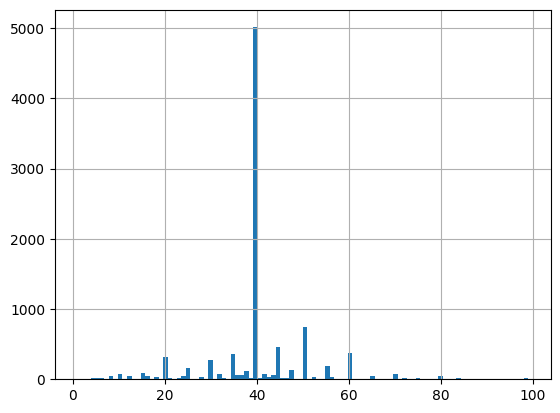

In [60]:
df["hours-per-week"].hist(bins=100)

We can see that missong values in the variable "hours-per-week" is aboout 10%. Thus we have to fill this values with something. Looking at this histogram plot we can see that the most frequent value is 40 hours a day. So, put it instead of nan

In [ ]:
df[(df["hours-per-week"].isna()) & (df["workclass"] == "?")]

In [30]:
df.workclass.unique()

array(['Private', 'Local-gov', '?', 'Self-emp-not-inc', 'Federal-gov',
       'State-gov', 'Self-emp-inc', 'Without-pay', 'Never-worked'],
      dtype=object)

In [ ]:
df[(df.occupation == "?") & (df["hours-per-week"].isna())]  # fill with 0?

In [44]:
df[(df.occupation != "?")]

,age,workclass,fnlwgt,education,educational-num,marital-status,occupation,relationship,race,gender,capital-gain,capital-loss,hours-per-week,native-country,income
0,25.0,Private,226802,11th,7,Never-married,Machine-op-inspct,Own-child,Black,Male,0.0,0.0,40.0,United-States,<=50K
1,38.0,Private,89814,HS-grad,9,Married-civ-spouse,Farming-fishing,Husband,White,Male,0.0,0.0,50.0,United-States,<=50K
2,28.0,Local-gov,336951,Assoc-acdm,12,Married-civ-spouse,Protective-serv,Husband,White,Male,0.0,0.0,40.0,United-States,>50K
3,44.0,Private,160323,Some-college,10,Married-civ-spouse,Machine-op-inspct,Husband,Black,Male,7688.0,0.0,40.0,United-States,>50K
5,34.0,Private,198693,10th,6,Never-married,Other-service,Not-in-family,White,Male,0.0,0.0,30.0,United-States,<=50K
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9610,NaN,Private,200939,HS-grad,9,Married-civ-spouse,Craft-repair,Husband,White,Male,0.0,0.0,40.0,United-States,>50K
9611,NaN,Private,110592,12th,8,Married-civ-spouse,Machine-op-inspct,Husband,White,Male,0.0,0.0,40.0,United-States,<=50K
9612,NaN,Private,167840,HS-grad,9,Married-civ-spouse,Handlers-cleaners,Husband,White,Male,0.0,2002.0,40.0,United-States,<=50K
9613,NaN,Private,274883,HS-grad,9,Married-civ-spouse,Transport-moving,Husband,White,Male,0.0,0.0,40.0,United-States,>50K


In [41]:
median = df["hours-per-week"].median()
# df["hours-per-week"] = df["hours-per-week"].fillna()

In [42]:
# fill only for those who work
df["hours-per-week"] = df["hours-per-week"].fillna(median).where((df.occupation != "?"), 
                                                                 df["hours-per-week"])

In [49]:
df[df["workclass"] == "Never-worked"]

,age,workclass,fnlwgt,education,educational-num,marital-status,occupation,relationship,race,gender,capital-gain,capital-loss,hours-per-week,native-country,income
7870,17.0,Never-worked,131593,11th,7,Never-married,?,Own-child,Black,Female,0.0,0.0,20.0,United-States,<=50K


In [47]:
# undefined class of occupation. maybe not work at all
df[df["hours-per-week"].isna()]

,age,workclass,fnlwgt,education,educational-num,marital-status,occupation,relationship,race,gender,capital-gain,capital-loss,hours-per-week,native-country,income
456,22.0,?,213291,Assoc-acdm,12,Never-married,?,Own-child,White,Male,0.0,0.0,NaN,United-States,<=50K
483,23.0,?,192028,Some-college,10,Never-married,?,Own-child,White,Female,0.0,0.0,NaN,United-States,<=50K
1083,62.0,?,103575,HS-grad,9,Married-civ-spouse,?,Husband,White,Male,5178.0,0.0,NaN,United-States,>50K
1308,33.0,?,207668,Bachelors,13,Never-married,?,Own-child,White,Male,0.0,0.0,NaN,United-States,<=50K
1392,31.0,?,186369,9th,5,Divorced,?,Unmarried,White,Female,0.0,0.0,NaN,United-States,<=50K
1699,26.0,?,102400,HS-grad,9,Married-civ-spouse,?,Own-child,White,Male,0.0,0.0,NaN,United-States,<=50K
1882,18.0,?,191817,11th,7,Never-married,?,Own-child,White,Male,0.0,0.0,NaN,Mexico,<=50K
1951,18.0,?,36779,11th,7,Never-married,?,Own-child,White,Female,0.0,0.0,NaN,United-States,<=50K
2537,83.0,?,29702,7th-8th,4,Married-civ-spouse,?,Husband,White,Male,0.0,0.0,NaN,United-States,<=50K
2565,23.0,?,172232,Some-college,10,Never-married,?,Own-child,White,Male,0.0,0.0,NaN,United-States,<=50K


In [51]:
# Also have nans in age
df["age"].mean()

38.72257560540118

In [53]:
median_age = df["age"].median()
df["age"] = df["age"].fillna(median_age)

In [56]:
df.isna().sum()

age                 0
workclass           0
fnlwgt              0
education           0
educational-num     0
marital-status      0
occupation          0
relationship        0
race                1
gender              1
capital-gain        1
capital-loss        1
hours-per-week     59
native-country      1
income              1
dtype: int64

In [59]:
df.shape

(9615, 15)

In [62]:
df = df.dropna()

In [63]:
df.shape

(9555, 15)

### Wrong values

In [69]:
df.describe(include='object')

,workclass,education,marital-status,occupation,relationship,race,gender,native-country,income
count,9555,9555,9555,9555,9555,9555,9555,9555,9555
unique,9,16,7,15,6,5,2,41,2
top,Private,HS-grad,Married-civ-spouse,Prof-specialty,Husband,White,Male,United-States,<=50K
freq,6573,3106,4290,1222,3785,8202,6373,8628,7300


I count categories from description and understand that some categories have some other values signed with "?"

In [64]:
df["workclass"].unique()

array(['Private', 'Local-gov', '?', 'Self-emp-not-inc', 'Federal-gov',
       'State-gov', 'Self-emp-inc', 'Without-pay', 'Never-worked'],
      dtype=object)

In [68]:
df["occupation"].unique()

array(['Machine-op-inspct', 'Farming-fishing', 'Protective-serv', '?',
       'Other-service', 'Prof-specialty', 'Craft-repair', 'Adm-clerical',
       'Exec-managerial', 'Sales', 'Priv-house-serv', 'Handlers-cleaners',
       'Transport-moving', 'Tech-support', 'Armed-Forces'], dtype=object)

### Main characteristics

In [72]:
# There is a class disbalance
df['income'].value_counts(normalize=True)

<=50K    0.763998
>50K     0.236002
Name: income, dtype: float64

In [73]:
df.describe()

,age,fnlwgt,educational-num,capital-gain,capital-loss,hours-per-week
count,9555.000000,9.555000e+03,9555.000000,9555.000000,9555.000000,9555.000000
mean,38.603140,1.883261e+05,10.084982,1127.054003,88.311565,40.424804
std,13.313325,1.050150e+05,2.561265,7914.055425,405.012116,11.669103
min,17.000000,1.376900e+04,1.000000,0.000000,0.000000,1.000000
25%,28.000000,1.157010e+05,9.000000,0.000000,0.000000,40.000000
50%,37.000000,1.778390e+05,10.000000,0.000000,0.000000,40.000000
75%,47.000000,2.374655e+05,12.000000,0.000000,0.000000,43.000000
max,90.000000,1.490400e+06,16.000000,99999.000000,3770.000000,99.000000


In [89]:
df[df["capital-gain"] > 50000]

,age,workclass,fnlwgt,education,educational-num,marital-status,occupation,relationship,race,gender,capital-gain,capital-loss,hours-per-week,native-country,income
79,44.0,Self-emp-inc,223881,HS-grad,9,Married-civ-spouse,Craft-repair,Husband,White,Male,99999.0,0.0,50.0,?,>50K
315,39.0,Private,198654,HS-grad,9,Divorced,Exec-managerial,Unmarried,Black,Female,99999.0,0.0,40.0,United-States,>50K
323,50.0,Self-emp-not-inc,165001,Prof-school,15,Married-civ-spouse,Prof-specialty,Husband,White,Male,99999.0,0.0,80.0,United-States,>50K
482,54.0,Self-emp-inc,159219,Prof-school,15,Married-civ-spouse,Prof-specialty,Husband,White,Male,99999.0,0.0,40.0,United-States,>50K
629,43.0,State-gov,125831,Bachelors,13,Never-married,Prof-specialty,Own-child,White,Male,99999.0,0.0,60.0,United-States,>50K
788,44.0,Private,217039,Prof-school,15,Married-civ-spouse,Prof-specialty,Husband,White,Male,99999.0,0.0,60.0,United-States,>50K
884,59.0,Self-emp-inc,77816,Prof-school,15,Married-civ-spouse,Prof-specialty,Husband,White,Male,99999.0,0.0,40.0,United-States,>50K
1008,44.0,Private,120277,Prof-school,15,Married-civ-spouse,Prof-specialty,Husband,White,Male,99999.0,0.0,60.0,United-States,>50K
1009,41.0,Private,191547,Masters,14,Married-civ-spouse,Exec-managerial,Husband,White,Male,99999.0,0.0,40.0,United-States,>50K
1031,43.0,Private,115562,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,99999.0,0.0,50.0,United-States,>50K


In [90]:
corr = df.corr() # строим матрицу корреляций

corr.style.background_gradient(cmap='coolwarm')

,age,fnlwgt,educational-num,capital-gain,capital-loss,hours-per-week
age,1.000000,-0.077629,0.003957,0.072488,0.049567,0.082251
fnlwgt,-0.077629,1.000000,-0.024504,-0.005903,-0.000335,-0.002953
educational-num,0.003957,-0.024504,1.000000,0.132963,0.082904,0.130805
capital-gain,0.072488,-0.005903,0.132963,1.000000,-0.031056,0.094493
capital-loss,0.049567,-0.000335,0.082904,-0.031056,1.000000,0.050094
hours-per-week,0.082251,-0.002953,0.130805,0.094493,0.050094,1.000000


In [91]:
for col in df.columns:
    try:
        print(col, np.corrcoef(df[col], df['income'])[0][1])
    except:
        pass